# XAI

Com base nos resultados da pesquisa, o método de Explainable AI (XAI) mais adequado para seu projeto de predição de euploidia em embriões é o LIME (Local Interpretable Model-agnostic Explanations), complementado por técnicas de modelagem probabilística. Este método atende à sua necessidade de obter porcentagens de probabilidade para cada classificação (euploide/aneuploide), superando as limitações da função sigmoidal.

Solução Proposta: Integração LIME + Modelagem Probabilística
1. LIME para Explicações Locais e Probabilísticas
Funcionamento:
- Gera explicações individuais para cada embrião analisado.
- Cria um modelo interpretável local (ex: regressão linear) ao redor da predição do modelo MLP, usando amostras perturbadas.
- Retorna pesos relativos das características (features) que influenciaram a decisão, convertíveis em probabilidades.

In [3]:
import sys
print(sys.executable)

c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\python.exe


In [4]:
!pip install lime
!{sys.executable} -m pip install lime

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.8 MB 11.8 MB/s eta 0:00:01
   --------------------- ------------------ 6.8/12.8 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.8 MB 22.5 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 20.6 MB/s eta 0:00:00
Using cached imageio-2.37.0-py3-none-any.whl (315 

In [5]:
import lime
import lime.lime_tabular
print("✅ LIME carregado com sucesso!")

✅ LIME carregado com sucesso!


🔎 Calculando LIME + Probabilidades para cada embrião...

=== MÉTRICAS DE DESEMPENHO ===
Acurácia: 0.976
AUC (baseado na sigmoid): 0.992
Recall Euploide (Sensibilidade): 0.951
Recall Aneuploide (Especificidade): 1.000

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        41
           1       1.00      0.95      0.97        41

    accuracy                           0.98        82
   macro avg       0.98      0.98      0.98        82
weighted avg       0.98      0.98      0.98        82



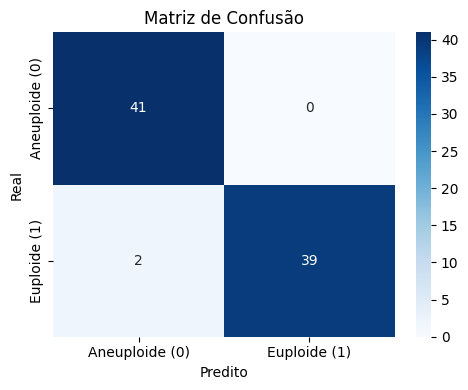

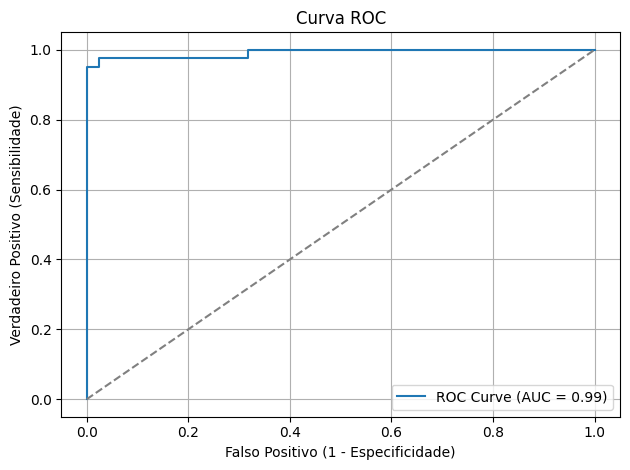


✅ Concluído com sucesso!
📄 Arquivo salvo como: Planilha_Com_LIME_Porcentagem.xlsx


In [16]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import numpy as np

# === 1. Carregar dados e modelo ===
df = pd.read_excel("PlanilhaNumerica.xlsx")
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

# === 2. Preparar os dados ===
X = df.drop(columns=["Ploidia"], errors="ignore")
y_true = df["Ploidia"]

colunas_treinadas = scaler.feature_names_in_
for col in colunas_treinadas:
    if col not in X.columns:
        X[col] = 0  

X = X[colunas_treinadas]
X_scaled = scaler.transform(X)

# === 3. Classificação com o modelo ===
classes_preditas = modelo.predict(X_scaled)

# === 4. Inicializa LIME ===
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=colunas_treinadas,
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# === 5. Gera probabilidade real da classe 1 e explicações LIME ===
print("🔎 Calculando LIME + Probabilidades para cada embrião...")
prob_euploidia = []

for i in range(len(X_scaled)):
    _ = explainer.explain_instance(X_scaled[i], modelo.predict_proba, num_features=len(colunas_treinadas))
    
    # Probabilidade real da classe 1 (euploide)
    prob = modelo.predict_proba(X_scaled[i].reshape(1, -1))[0][1]
    prob_euploidia.append(round(prob * 100, 2))

# === 6. Atualiza o dataframe ===
df["Classe_Prevista"] = classes_preditas
df["Prob_Euploidia_LIME"] = prob_euploidia

# === 7. Métricas de desempenho ===
prob_raw = modelo.predict_proba(X_scaled)[:, 1]
acc = accuracy_score(y_true, classes_preditas)
auc = roc_auc_score(y_true, prob_raw)

cm = confusion_matrix(y_true, classes_preditas)
tn, fp, fn, tp = cm.ravel()
recall_euploide = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_aneuploide = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n=== MÉTRICAS DE DESEMPENHO ===")
print(f"Acurácia: {acc:.3f}")
print(f"AUC (baseado na sigmoid): {auc:.3f}")
print(f"Recall Euploide (Sensibilidade): {recall_euploide:.3f}")
print(f"Recall Aneuploide (Especificidade): {recall_aneuploide:.3f}")
print("\n=== Classification Report ===")
print(classification_report(y_true, classes_preditas))

# === 8. Matriz de Confusão ===
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# === 9. Curva ROC ===
fpr, tpr, thresholds = roc_curve(y_true, prob_raw)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo (1 - Especificidade)")
plt.ylabel("Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 10. Salvar a planilha final ===
df.to_excel("Planilha_Com_LIME_Porcentagem.xlsx", index=False)

print("\n✅ Concluído com sucesso!")
print("📄 Arquivo salvo como: Planilha_Com_LIME_Porcentagem.xlsx")